
# Bibliotécas

In [ ]:
#!pip install tensorflow --upgrade
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, r_regression
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

!pip install keras-tuner --upgrade
import keras_tuner as kt
import tensorflow as tf
from google.colab import output
import time

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN, Reshape, InputLayer
from keras.layers import Dropout
from keras.utils import plot_model
from keras.metrics import RootMeanSquaredError
from keras.utils import set_random_seed
from keras.callbacks import EarlyStopping

import gc

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
set_random_seed(seed)
global train_tf, test_tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
# Reset Keras Session
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del m # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 545148526931886819
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10677719489930545987
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


#Carregar dados

In [ ]:
import chardet
import pandas as pd
import glob
all_files = glob.glob("/content/*.csv")

for filename in all_files:
  with open(filename, 'rb') as f:
    encoding = chardet.detect(f.read())['encoding']
    print(f"Encoding of {filename}: {encoding}")

Encoding of /content/dados (4).csv: ascii


In [ ]:

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, encoding = encoding,
                     decimal=",", delimiter=";")
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True).astype('str')
df.drop(columns=[col for col in df.columns if 'Unnamed' in col], inplace=True)
df = df.drop_duplicates()
df.replace('0.0', np.nan, inplace=True)
df.replace('time (ms)', np.nan, inplace=True)
df.replace('tempo (ms)', np.nan, inplace=True)
df.dropna(inplace=True)
df = df.astype(float)
df.rename(columns={'amb_t (°C)': 'most_t', 'mos_t (°C)': 'amb_t',
                   'tempo (ms)': 'tempo',	'pwm ()':'pwm'}, inplace=True)
df.to_csv('df.csv', encoding='utf-8', index=False)

In [ ]:
df.head()


,pwm,amb_t,mos_t
0,255.0,23.1250,53.6875
1,255.0,23.1875,53.9375
2,255.0,23.1250,54.6250
3,255.0,23.1875,55.6875
4,255.0,23.1875,56.9375


In [ ]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_n = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_n.head()

,pwm,amb_t,mos_t
0,255.0,23.1250,53.6875
1,255.0,23.1875,53.9375
2,255.0,23.1250,54.6250
3,255.0,23.1875,55.6875
4,255.0,23.1875,56.9375


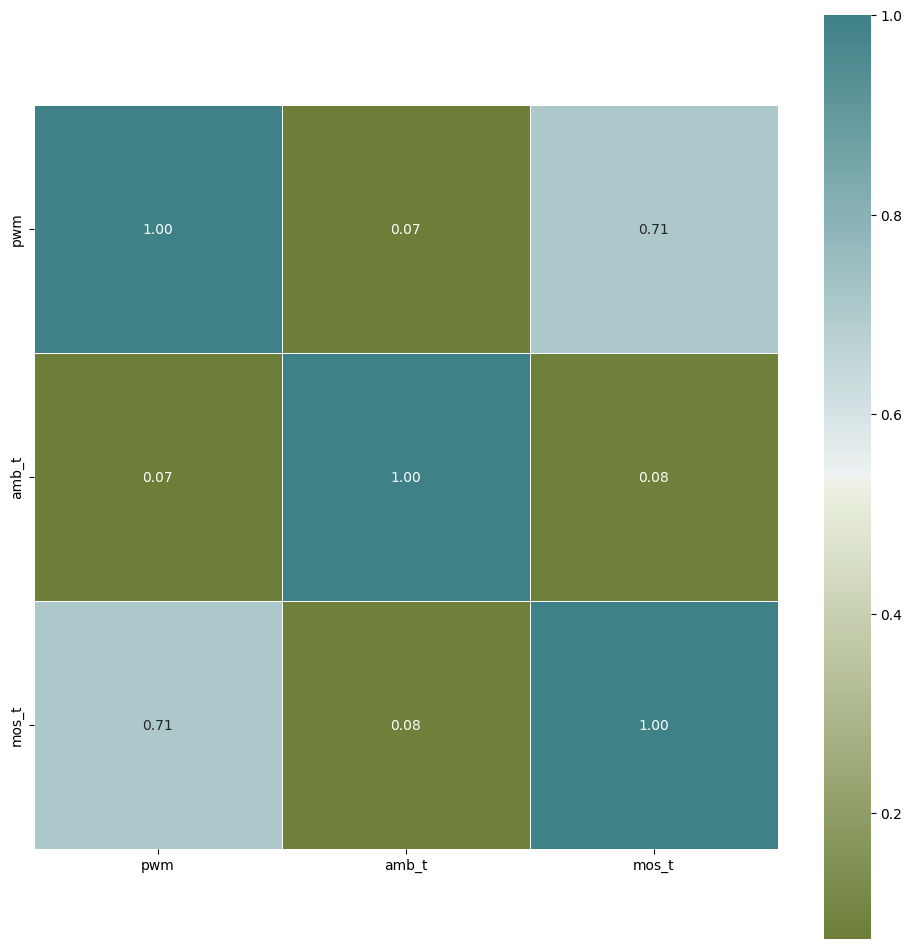

In [ ]:
f,ax=plt.subplots(figsize=(12,12))
corr=df_n.corr(method= 'pearson').abs()

sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f',
            mask= np.zeros_like(corr,dtype=bool),
            cmap=sns.diverging_palette(100,200,as_cmap=True),
            square=True, ax=ax)

plt.show()

In [ ]:
# prompt: converta as coluna em float

df_n.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4979 entries, 0 to 4978
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pwm     4979 non-null   float64
 1   amb_t   4979 non-null   float64
 2   mos_t   4979 non-null   float64
dtypes: float64(3)
memory usage: 116.8 KB


In [ ]:
to_filter = [column for column in corr.columns if any((corr[column] > 0.50) *  (corr[column] < 1.0))]
to_filter


['pwm', 'mos_t']

In [ ]:
#df_nn = df_n[to_filter]
df_nn = df_n.copy()
df_nn.head()

,pwm,amb_t,mos_t
0,255.0,23.1250,53.6875
1,255.0,23.1875,53.9375
2,255.0,23.1250,54.6250
3,255.0,23.1875,55.6875
4,255.0,23.1875,56.9375


In [ ]:
# Print the dataframe
# df.head(10)
# prompt: do dataframe df separe a coluna pm para o vetor y e o restante das colunas no vetor x

X = df_nn.drop(['mos_t'], axis = 1).to_numpy()
y = df_nn['mos_t'].to_numpy()

print(X.shape)

X_new = SelectKBest(mutual_info_regression, k='all').fit_transform(X, y)
print(X_new.shape)

X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_scaled = X_scaler.fit_transform(X_new)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

X_scaled = np.append(X_scaled, y_scaled, axis=1)

print(X_scaled.shape)
print(y_scaled.shape)

(4979, 2)
(4979, 2)
(4979, 3)
(4979, 1)


In [ ]:
# Set window of past points for LSTM model
window = 42
#falar sobre Holdout Method; Cross-Validation; Leave-One-Out Cross-Validation (LOOCV)
# Split ~80/10/0.2 into train/test/val data
last = int(len(y_scaled)/20.0)
Xtrain = X_scaled[:-last]
Xval = X_scaled[-last-window:]

ytrain = y_scaled[:-last]
yval = y_scaled[-last-window:]

#Xval = Xval[-600:,:]
#yval = yval[-600:,:]

print(Xtrain.shape)
print(Xval.shape)
print(ytrain.shape)
print(yval.shape)

(4731, 3)
(290, 3)
(4731, 1)
(290, 1)


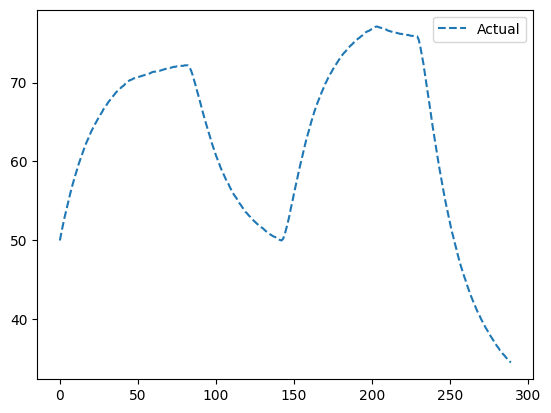

In [ ]:
plt.figure()
plt.plot(y_scaler.inverse_transform(yval),'--',label='Actual')
plt.legend()

In [ ]:
# Store window number of points as a sequence
xin = []
next_y = []
for i in range(window,len(Xtrain)):
    xin.append(Xtrain[i-window:i]);
    next_y.append(ytrain[i])

In [ ]:
# prompt: exibir o elemento 10 de xin

print(xin[0])


[[1.         0.         0.37113402]
 [1.         0.02857143 0.37457045]
 [1.         0.         0.38402062]
 [1.         0.02857143 0.39862543]
 [1.         0.02857143 0.41580756]
 [1.         0.         0.43556701]
 [1.         0.         0.45704467]
 [1.         0.02857143 0.47852234]
 [1.         0.02857143 0.5       ]
 [1.         0.         0.52147766]
 [1.         0.05714286 0.79037801]
 [1.         0.02857143 0.8024055 ]
 [1.         0.05714286 0.81271478]
 [1.         0.02857143 0.82388316]
 [1.         0.02857143 0.83333333]
 [1.         0.02857143 0.8419244 ]
 [1.         0.02857143 0.85137457]
 [1.         0.02857143 0.85996564]
 [1.         0.02857143 0.8685567 ]
 [1.         0.05714286 0.87628866]
 [1.         0.02857143 0.88402062]
 [1.         0.05714286 0.89089347]
 [1.         0.02857143 0.89776632]
 [1.         0.02857143 0.90463918]
 [1.         0.02857143 0.91065292]
 [1.         0.02857143 0.91752577]
 [1.         0.02857143 0.92353952]
 [1.         0.02857143 0.92

In [ ]:
print(next_y[0:3])

[array([0.99054983]), array([0.99398625]), array([0.99656357])]


In [ ]:
# Transformando os dados para array
xin, next_y = np.array(xin), np.array(next_y)
print(xin.shape)
print(next_y.shape)

(4689, 42, 3)
(4689, 1)


In [ ]:
# Reshape data to format for LSTM
xin = xin.reshape(xin.shape[0], xin.shape[1],xin.shape[2])#, 1)
print(xin.shape)
print(next_y.shape)

(4689, 42, 3)
(4689, 1)


In [ ]:
print(xin[0:3])

[[[1.         0.         0.37113402]
  [1.         0.02857143 0.37457045]
  [1.         0.         0.38402062]
  [1.         0.02857143 0.39862543]
  [1.         0.02857143 0.41580756]
  [1.         0.         0.43556701]
  [1.         0.         0.45704467]
  [1.         0.02857143 0.47852234]
  [1.         0.02857143 0.5       ]
  [1.         0.         0.52147766]
  [1.         0.05714286 0.79037801]
  [1.         0.02857143 0.8024055 ]
  [1.         0.05714286 0.81271478]
  [1.         0.02857143 0.82388316]
  [1.         0.02857143 0.83333333]
  [1.         0.02857143 0.8419244 ]
  [1.         0.02857143 0.85137457]
  [1.         0.02857143 0.85996564]
  [1.         0.02857143 0.8685567 ]
  [1.         0.05714286 0.87628866]
  [1.         0.02857143 0.88402062]
  [1.         0.05714286 0.89089347]
  [1.         0.02857143 0.89776632]
  [1.         0.02857143 0.90463918]
  [1.         0.02857143 0.91065292]
  [1.         0.02857143 0.91752577]
  [1.         0.02857143 0.92353952]
 

In [ ]:
print("Shape de xin após redimensionamento:", xin.shape)
print("que significa que temos "+ str(xin.shape[0]) + " exemplos, cada um com "+ str(xin.shape[1])+ " linhas e "+ str(xin.shape[2])+ " colunas,")
print("e uma dimensão adicional com tamanho 1, que representa o canal de entrada para a LSTM.")
print("Todos os exemplos estão em um vetor coluna.")


Shape de xin após redimensionamento: (4689, 42, 3)
que significa que temos 4689 exemplos, cada um com 42 linhas e 3 colunas,
e uma dimensão adicional com tamanho 1, que representa o canal de entrada para a LSTM.
Todos os exemplos estão em um vetor coluna.


In [ ]:
print(xin.shape)
print(next_y.shape)
X_train, X_test, y_train, y_test = train_test_split(xin, next_y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4689, 42, 3)
(4689, 1)
(3751, 42, 3)
(938, 42, 3)
(3751, 1)
(938, 1)


In [ ]:
def build_dataset2(window=180, batch=192):
  dataset = tf.keras.utils.timeseries_dataset_from_array(
      X_scaled,
      targets=y_scaled,
      sequence_length=window,
      sequence_stride=window,
      shuffle=True,
      batch_size=batch)
  return dataset

In [ ]:
def build_dataset(window=180, batch=192):
  global train_tf, test_tf
  #falar sobre Holdout Method; Cross-Validation; Leave-One-Out Cross-Validation (LOOCV)
  # Split ~80/10/0.2 into train/test/val data
  last = int(len(y_scaled)/20.0)
  Xtrain = X_scaled[:-last]
  Xval = X_scaled[-last-window:]

  ytrain = y_scaled[:-last]
  yval = y_scaled[-last-window:]

  # Store window number of points as a sequence
  xin = []
  next_y = []
  for i in range(window,len(Xtrain)):
      xin.append(Xtrain[i-window:i]);
      next_y.append(ytrain[i])

  # Transformando os dados para array
  xin, next_y = np.array(xin), np.array(next_y)

  def optimize(train_dataset):
    def map_function(x, y):
      return x , y

    #train_dataset = train_dataset.repeat()
    train_dataset = train_dataset.map(map_function, tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.batch(batch)
    train_dataset = train_dataset.prefetch(buffer_size=64)
    return train_dataset

  # Reshape data to format for LSTM
  xin = xin.reshape(xin.shape[0], xin.shape[1],xin.shape[2])#, 1)
  X_train, X_test, y_train, y_test = train_test_split(xin, next_y, test_size=0.2, random_state=seed)
  train_tf = optimize(tf.data.Dataset.from_tensor_slices((X_train,y_train)))#.batch(batch)
  test_tf = optimize(tf.data.Dataset.from_tensor_slices((X_test,y_test)))#.batch(batch)

  return train_tf, test_tf

In [ ]:
train_tf, test_tf = build_dataset(window=42, batch=32)
train_tf

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 42, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

# Modelo

In [ ]:
# # Initialize LSTM model
def build_model():
  m = Sequential()
  #m.add(Reshape(target_shape=(xin.shape[1], xin.shape[2]), input_shape=(xin.shape[1], xin.shape[2])))
  m.add(InputLayer(input_shape=(xin.shape[1], xin.shape[2])))
  m.add(LSTM(units=24, return_sequences=True))
  #m.add(Dropout(0.1))
  m.add(LSTM(units=64, return_sequences=True))
  m.add(LSTM(units=40, return_sequences=True))
  m.add(Dropout(0.3))
  m.add(LSTM(units=64, return_sequences=True))
  m.add(Dropout(0.1))
  m.add(LSTM(units=64, return_sequences=False))
  m.add(Dropout(0.1))
  m.add(Dense(units=1))
  m.compile(optimizer = tf.keras.optimizers.Adam(
      learning_rate = 0.007),
      loss = 'mean_squared_error',
      metrics=['mean_squared_error'])
  return m

# Inicializar o modelo RNN
#m = Sequential()
# Adicionar a camada RNN
#m.add(SimpleRNN(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
# Adicionar outra camada RNN (se necessário)
#m.add(SimpleRNN(units=50, return_sequences=False))
# Adicionar a camada de saída
#m.add(Dense(units=1))
# Compilar o modelo
#m.compile(optimizer='adam', loss='mean_squared_error')


# # Inicializar o modelo GRU
# m = Sequential()
# # Adicionar a camada GRU
# m.add(GRU(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
# m.add(Dropout(0.2))
# # Adicionar outra camada GRU (se necessário)
# m.add(GRU(units=50, return_sequences=False))
# m.add(Dropout(0.2))
# # Adicionar a camada de saída
# m.add(Dense(units=1))
# # Compilar o modelo
# m.compile(optimizer='adam', loss='mean_squared_error')


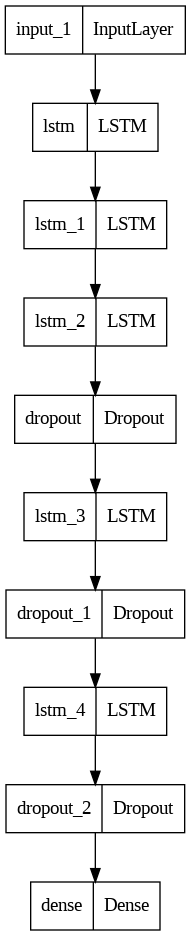

In [ ]:
m = build_model()
plot_model(m)


In [ ]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 42, 24)            2688      
                                                                 
 lstm_1 (LSTM)               (None, 42, 64)            22784     
                                                                 
 lstm_2 (LSTM)               (None, 42, 40)            16800     
                                                                 
 dropout (Dropout)           (None, 42, 40)            0         
                                                                 
 lstm_3 (LSTM)               (None, 42, 64)            26880     
                                                                 
 dropout_1 (Dropout)         (None, 42, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                3

# Tune

In [ ]:
class MyHyperModel(kt.HyperModel):
  def build(self, hp):
    window = hp.Int('window', 10, 200, step=8, default=180)
    batch = hp.Int('batch', 32, 512, step=32, default=192)

    model = Sequential()
    #model.add(Reshape(target_shape=(xin.shape[1], xin.shape[2]), input_shape=(xin.shape[1], xin.shape[2])))
    model.add(InputLayer(input_shape=(window, xin.shape[2])))
    model.add(LSTM(units= hp.Int('lstm_0_units', 16, 32, step=4, default=24), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_0', 0, 0.5, step=0.1, default=0.0)))

    for i in range(hp.Int('n_layers', 1, 4)):
      model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=56,max_value=96,step=8),return_sequences=True))
      model.add(Dropout(hp.Float(f'dropout_{i}', 0, 0.5, step=0.1, default=0.0)))

    model.add(LSTM(units= hp.Int('lstm_end_units', 56, 96, step=8, default=64), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_end', 0, 0.5, step=0.1, default=0.1)))
    model.add(Dense(units=1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))

    model.compile(
      optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log', default=0.007)),
      loss='mean_squared_error',
      metrics=['mean_squared_error'])
    return model

  def fit(self, hp, model, validation_data=None, **kwargs):
    window = hp.get("window")
    batch = hp.get("batch")
    train_tf, test_tf = build_dataset(window, batch)
    steps_per_epoch = train_tf.cardinality().numpy() // batch
    history = model.fit(train_tf,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=test_tf,
                        **kwargs)
    return history

In [ ]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [ ]:
!rm -r /content/my_dir

In [ ]:
tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_loss',
    max_epochs=10,
    hyperband_iterations=2,
    factor=3,
    overwrite=True,
    directory='my_dir',
    max_consecutive_failed_trials=50  # Increase the limit to 5
    )

In [ ]:
with strategy.scope():
  tf.keras.mixed_precision.set_global_policy("mixed_float16")  # Set the mixed precision policy
  try:
    tuner.search(train_tf,
                  validation_steps=10,
                  epochs=10,
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
  finally:
    pass

Trial 44 Complete [00h 00m 02s]

Best val_loss So Far: 0.05503540113568306
Total elapsed time: 00h 07m 33s


IndexError: pop from empty list

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
m = best_model
print(best_hyperparameters.values)

{'window': 42, 'batch': 32, 'lstm_0_units': 24, 'dropout_0': 0.2, 'n_layers': 2, 'lstm_end_units': 80, 'dropout_end': 0.2, 'dense_activation': 'sigmoid', 'learning_rate': 0.00021420783979311065, 'lstm_1_units': 96, 'dropout_1': 0.2, 'lstm_2_units': 80, 'dropout_2': 0.1, 'lstm_3_units': 80, 'dropout_3': 0.4, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [ ]:
X_train.shape

(3751, 42, 3)

# Treino

In [ ]:
ear = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [ ]:
reset_keras()
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

16155
Number of devices: 1


In [ ]:
# Fit LSTM model
with strategy.scope():
  m = build_model()
  #train_tf = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32)
  #test_tf = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32)
  history = m.fit(train_tf,
                  epochs = 50,
                  verbose=1,
                  callbacks = EarlyStopping(monitor='val_loss', patience=10),
                  validation_data=test_tf,
                  #steps_per_epoch=len(X_train) // 32,
                  )

Epoch 1/50
118/118 [==============================] - 31s 77ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/50
118/118 [==============================] - 2s 18ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 3.8708e-04 - val_mean_squared_error: 3.8708e-04
Epoch 3/50
118/118 [==============================] - 3s 23ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 2.8943e-04 - val_mean_squared_error: 2.8943e-04
Epoch 4/50
118/118 [==============================] - 2s 17ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 6.6937e-04 - val_mean_squared_error: 6.6937e-04
Epoch 5/50
118/118 [==============================] - 2s 17ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 2.4986e-04 - val_mean_squared_error: 2.4986e-04
Epoch 6/50
118/118 [==============================] - 2s 17ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 1.4405e-04 - val_mean_squared

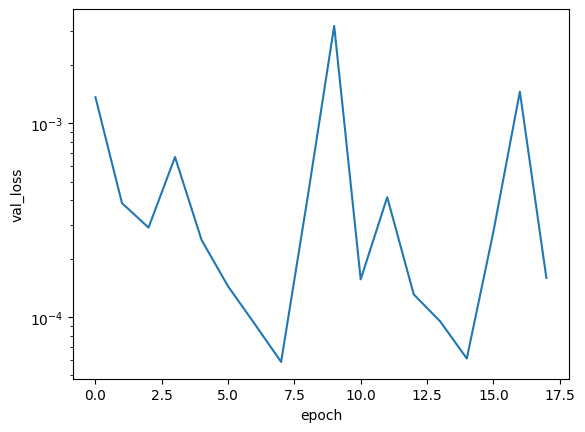

In [ ]:
plt.figure()
plt.ylabel('val_loss'); plt.xlabel('epoch')
plt.semilogy(history.history['val_loss'])

# Teste

In [ ]:
m.evaluate(X_test, y_test)

30/30 [==============================] - 2s 8ms/step - loss: 1.5919e-04 - mean_squared_error: 1.5919e-04


[0.00015919454745016992, 0.00015919454745016992]

8/8 [==============================] - 2s 7ms/step


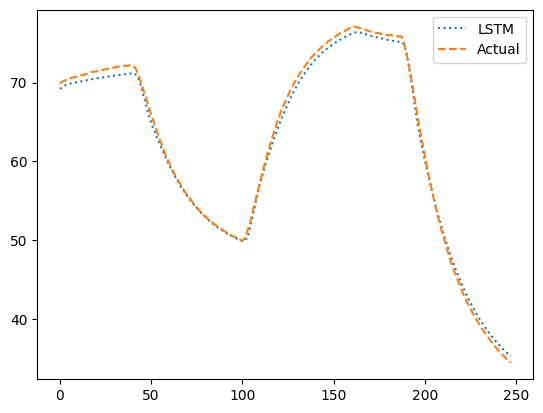

In [ ]:
# Store "window" points as a sequence
xin_1 = []
next_y1 = []
for i in range(window,len(yval)):
    xin_1.append(Xval[i-window:i])
    next_y1.append(yval[i])

# Reshape data to format for LSTM
X_val, y_val = np.array(xin_1), np.array(next_y1)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))

# Predict the next value (1 step ahead)
y_pred = m.predict(X_val)

# Plot prediction vs actual for test data
plt.figure()
plt.plot(y_scaler.inverse_transform(y_pred),':',label='LSTM')
plt.plot(y_scaler.inverse_transform(y_val),'--',label='Actual')
plt.legend()

In [ ]:
# prompt: salve y_pred e y_val em um arquivo dataframe

import pandas as pd

# Create a DataFrame with y_pred and y_val
df_pred = pd.DataFrame({'y_pred': y_pred.flatten(), 'y_val': y_val.flatten()})

# Save the DataFrame to a CSV file
df_pred.to_csv('y_pred_y_val.csv', index=False)


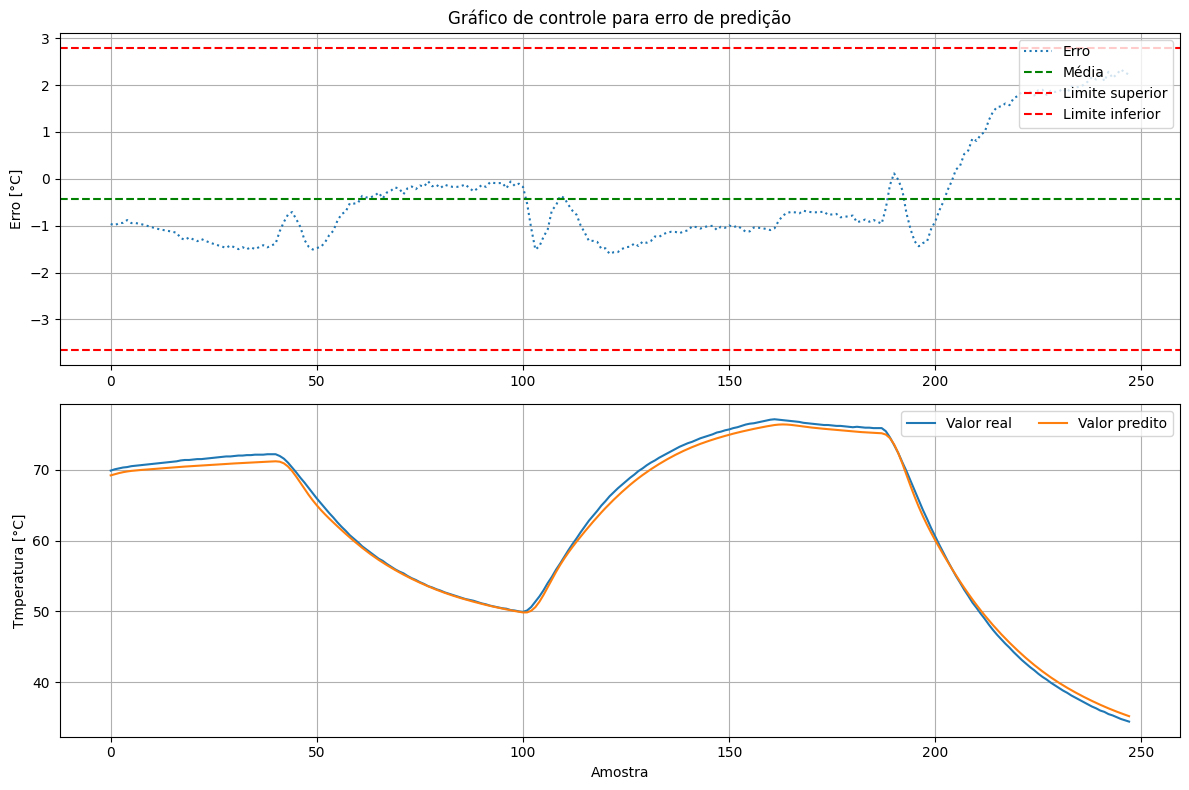

mean: -0.43, std: 1.08, li: -3.66, ls: 2.79


In [ ]:
diff = 100*(y_scaler.inverse_transform(y_pred) - y_scaler.inverse_transform(y_val))/y_scaler.inverse_transform(y_val)
import matplotlib.pyplot as plt
# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the error on the first subplot
ax1.plot(diff, ':', label='Erro')
ax1.set_ylabel('Erro [°C]')
ax1.set_title('Gráfico de controle para erro de predição')

# Add control limits
mean = diff.mean()
std = diff.std()
li = mean - 3*std
ls = mean + 3*std

ax1.axhline(y=mean, color='g', linestyle='--', label='Média')
ax1.axhline(y=ls, color='r', linestyle='--', label='Limite superior')
ax1.axhline(y=li, color='r', linestyle='--', label='Limite inferior')
ax1.legend(loc='upper right', ncols=1)
ax1.grid(True)

# Plot the actual and predicted values on the second subplot
ax2.plot(y_scaler.inverse_transform(y_val), '-', label='Valor real')
ax2.plot(y_scaler.inverse_transform(y_pred), '-', label='Valor predito')
ax2.set_xlabel('Amostra')
ax2.set_ylabel('Tmperatura [°C]')
ax2.grid(True)

# Add a legend to the second subplot
ax2.legend(loc='upper right', ncols=2)

# Show the plot
plt.tight_layout()
plt.show()
print(f"mean: {mean:.2f}, std: {std:.2f}, li: {li:.2f}, ls: {ls:.2f}")

In [ ]:
# Using predicted values to predict next step
xin_2 =[]
y_next_2 = []
X_pred = Xval.copy()
fim = len(X_pred)
for i in range(window,len(X_pred)):
    xin_2 = X_pred[i-window:i].reshape((1, window, X_pred.shape[1]))
    X_pred[i,-1] = float(m.predict(xin_2, verbose=0))
    eta = 100*i/fim
    if int(10*eta) % 10 == 0:
        output.clear()
        print(f"{eta:.1f}% done")
        #time.sleep(0.1)

92.1% done


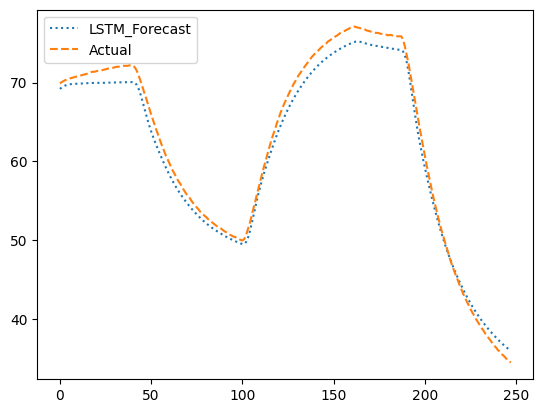

In [ ]:
# Plot prediction vs actual for test data 10
plt.figure()
plt.plot(y_scaler.inverse_transform(X_pred[window:,-1].reshape(-1, 1)),':',label='LSTM_Forecast')
plt.plot(y_scaler.inverse_transform(y_val),'--',label='Actual')
plt.legend()

In [ ]:
m.save("model_p_n" + ".h5")
dump(history, "history_p_n.joblib", compress=3)
dump(X_scaler, "X_scaler_p_n.joblib", compress=3)
dump(y_scaler, "y_scaler_p_n.joblib", compress=3)

print ("Model saved")

Model saved


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download('model_p_n.h5')
files.download('history_p_n.joblib')
files.download('X_scaler_p_n.joblib')
files.download('y_scaler_p_n.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
m = tf.keras.models.load_model(
    "model_p.h5")
history = load("history_p.joblib")
print ("Model loaded")

Model loaded


In [ ]:
from google.colab import runtime
runtime.unassign()